# Importing Libraries

In [1]:
!pip install opencv-python
!pip install tqdm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import cv2
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from itertools import combinations
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [5]:
!unzip Siamese.zip

Archive:  Siamese.zip
   creating: Siamese/
   creating: Siamese/personA/
   creating: Siamese/personA/Test/
  inflating: Siamese/personA/Test/personA_10.png  
  inflating: Siamese/personA/Test/personA_13.png  
  inflating: Siamese/personA/Test/personA_2.png  
  inflating: Siamese/personA/Test/personA_20.png  
  inflating: Siamese/personA/Test/personA_27.png  
  inflating: Siamese/personA/Test/personA_29.png  
  inflating: Siamese/personA/Test/personA_42.png  
  inflating: Siamese/personA/Test/personA_SigVerificationTestLabels.csv  
  inflating: Siamese/personA/Test/personA_33.png  
   creating: Siamese/personA/Train/
  inflating: Siamese/personA/Train/personA_30.png  
  inflating: Siamese/personA/Train/personA_1.png  
  inflating: Siamese/personA/Train/personA_11.png  
  inflating: Siamese/personA/Train/personA_12.png  
  inflating: Siamese/personA/Train/personA_14.png  
  inflating: Siamese/personA/Train/personA_15.png  
  inflating: Siamese/personA/Train/personA_16.png  
  inflating

# Accessing the data

In [6]:
path = "/content/Siamese"
training_data = []
for i, folder in enumerate(os.listdir(path)):
    for sub_folder in os.listdir(path+"/"+folder):
        if os.path.basename(sub_folder) == "Train":
            training_path = path+"/"+folder+"/"+sub_folder
            files = os.listdir(path+"/"+folder+"/"+sub_folder)
            for file in files:
                if file.endswith(".csv"):
                    training_data.append(f"{training_path}/{file}")

training_triplets = []
for person_csv_path in training_data:
    person_file_data = pd.read_csv(person_csv_path)
    forged_signs = person_file_data[person_file_data["label"] == "forged"]["image_name"].values
    real_signs = person_file_data[person_file_data["label"] == "real"]["image_name"].values
    real_pairs = list(combinations(real_signs, 2))
    training_triplets.extend([(anchor, positive, negative) for (anchor, positive) in real_pairs for negative in forged_signs])

Now we have unique triplets for all the data. We need to preprocess the images from the image names and labels from these triplets.

# Preprocessing Functions

In [7]:
def process_batch(batch):
    def get_image_from_path(image_name, path):
        for i, folder in enumerate(os.listdir(path)):
            for sub_folder in os.listdir(path+"/"+folder):
                if os.path.basename(sub_folder) == "Train":
                    if image_name in os.listdir(path+"/"+folder+"/"+sub_folder):
                        image = cv2.imread(path+"/"+folder+"/"+sub_folder+"/"+image_name)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image = cv2.resize(image, (128, 128))
                        image = image.reshape(1, 128, 128)
                        image = image.astype(np.float32)
                        image = torch.tensor(image)
                        return image

    def get_images_from_triplet(triplet, path):
        anchor = get_image_from_path(triplet[0], path)
        positive = get_image_from_path(triplet[1], path)
        negative = get_image_from_path(triplet[2], path)
        return anchor, positive, negative

    processed_batch = []
    for triplet in zip(*batch):
        anchor, positive, negative = get_images_from_triplet(triplet, path)
        processed_batch.append((anchor, positive, negative))
    return processed_batch

# Creating Dataset and Dataloader

In [8]:
class SiameseDataset(Dataset):
    def __init__(self, triplets):
        self.__triplets__ = triplets

    def __len__(self):
        return len(self.__triplets__)

    def __getitem__(self, idx):
        return self.__triplets__[idx]

Now everything is set. let's get the training and testing data

In [9]:
training_data = SiameseDataset(training_triplets)
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)

In [10]:
del training_triplets, training_data  #freeing up memory

In [11]:
class Siamese_network(nn.Module):
    def __init__(self):
        super(Siamese_network, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, padding_mode="zeros"),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),  # Reduces by 1 in each dimension
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, padding_mode="zeros"),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1)  # Reduces by 1 in each dimension
        )


        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(508032, 128)
        )

    def forward_once(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output = F.pairwise_distance(output1, output2, p=2)
        return output

# Loss Function

In [12]:
import torch.nn.functional as F
from tqdm import tqdm

triplet_loss = nn.TripletMarginLoss(margin=100, p=2, eps=1e-7,reduction="mean")

# Training Loop

In [32]:
model = Siamese_network()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 3

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_batch_accuracy = 0.0
    total_correct_preds = 0
    total_samples = 0

    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch", leave=False)

    for batch in pbar:
        processed_batch = process_batch(batch)
        anchors, positives, negatives = zip(*processed_batch)
        anchors = torch.stack(anchors).to(device)
        positives = torch.stack(positives).to(device)
        negatives = torch.stack(negatives).to(device)

        optimizer.zero_grad()

        anchor_embed = model.forward_once(anchors)
        pos_embed = model.forward_once(positives)
        neg_embed = model.forward_once(negatives)
        loss = triplet_loss(anchor_embed, pos_embed, neg_embed)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        with torch.no_grad():
            pos_dist = model(anchors, positives)
            neg_dist = model(anchors, negatives)
            correct_preds = (pos_dist < neg_dist).sum().item()
            total_preds = anchors.size(0)

            batch_accuracy = (correct_preds / total_preds) * 100
            running_batch_accuracy += batch_accuracy
            total_correct_preds += correct_preds
            total_samples += total_preds

        avg_loss = running_loss / (pbar.n + 1)
        avg_acc = running_batch_accuracy / (pbar.n + 1)

        pbar.set_postfix({
            "avg_epoch_Loss": f"{avg_loss:.4f}",
            "avg_epoch_Acc": f"{avg_acc:.2f}%",
            "current_batch_Acc": f"{batch_accuracy:.2f}%"
        })

    epoch_loss = running_loss / len(train_dataloader)
    avg_batch_acc = running_batch_accuracy / len(train_dataloader)
    total_epoch_acc = (total_correct_preds / total_samples) * 100

    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Final Avg Loss          : {epoch_loss:.4f}")
    print(f"  Avg Batch Accuracy      : {avg_batch_acc:.2f}%")
    print(f"  Total Prediction Accuracy: {total_epoch_acc:.2f}%\n")



Epoch 1 Summary:
  Final Avg Loss          : 2.5325
  Avg Batch Accuracy      : 99.91%
  Total Prediction Accuracy: 99.91%




Epoch 2 Summary:
  Final Avg Loss          : 0.9873
  Avg Batch Accuracy      : 100.00%
  Total Prediction Accuracy: 100.00%




Epoch 3 Summary:
  Final Avg Loss          : 0.3618
  Avg Batch Accuracy      : 100.00%
  Total Prediction Accuracy: 100.00%



# Preparing Test Data

In [33]:
testing_data = []
for i, folder in enumerate(os.listdir(path)):
    for sub_folder in os.listdir(path+"/"+folder):
        if os.path.basename(sub_folder) == "Test":
            testing_path = path+"/"+folder+"/"+sub_folder
            files = os.listdir(path+"/"+folder+"/"+sub_folder)
            for file in files:
                if file.endswith(".csv"):
                    testing_data.append(f"{testing_path}/{file}")

testing_pairs = []
for person_csv_path in testing_data:
    person_file_data = pd.read_csv(person_csv_path)
    forged_signs = person_file_data[person_file_data["label"] == "forged"]["image_name"].values
    real_signs = person_file_data[person_file_data["label"] == "real"]["image_name"].values
    real_pairs = list(combinations(real_signs, 2))
    testing_pairs.extend([(anchor, positive, 1) for anchor, positive in real_pairs])
    testing_pairs.extend([(anchor, negative, 0) for anchor in real_signs for negative in forged_signs])

In [34]:
class SiameseDataset_testing(Dataset):
    def __init__(self, pairs):
        # Expected: pairs = [(anchor, sample, label), ...]
        self.anchors = [anchor for anchor, _, _ in pairs]
        self.samples = [sample for _, sample, _ in pairs]
        self.labels = [label for _, _, label in pairs]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.anchors[idx], self.samples[idx], self.labels[idx]

testing_data = SiameseDataset_testing(testing_pairs)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=True)

def process_testing_batch(batch):
    def get_image_from_path(image_name, path):
        for i, folder in enumerate(os.listdir(path)):
            for sub_folder in os.listdir(path+"/"+folder):
                if os.path.basename(sub_folder) == "Test":
                    if image_name in os.listdir(path+"/"+folder+"/"+sub_folder):
                        image = cv2.imread(path+"/"+folder+"/"+sub_folder+"/"+image_name)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                        image = cv2.resize(image, (128, 128))
                        image = image.reshape(1, 128, 128)
                        image = image.astype(np.float32)
                        image = torch.tensor(image)
                        return image

    def get_images_from_pair(pair, path):
        anchor = get_image_from_path(pair[0], path)
        sample = get_image_from_path(pair[1], path)
        return anchor, sample

    processed_batch = []
    for pair in zip(*batch):
        label  = pair[-1].item()
        anchor, sample =  get_images_from_pair(pair, path)
        processed_batch.append((anchor, sample, label))
    return processed_batch

# Testing

Median =  8660.0
Mean =  9423.845454545455


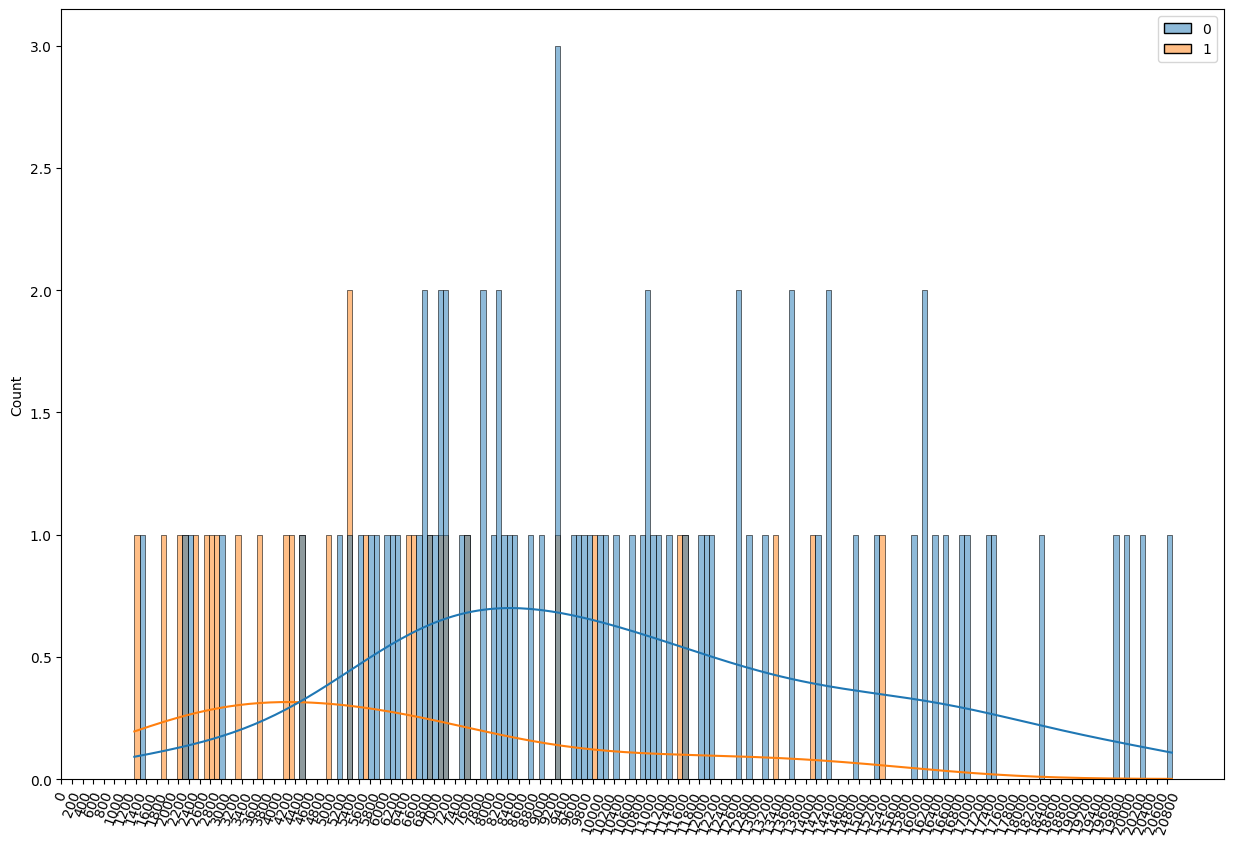


Classification Report:
              precision    recall  f1-score   support

           0     0.8152    0.9375    0.8721        80
           1     0.7222    0.4333    0.5417        30

    accuracy                         0.8000       110
   macro avg     0.7687    0.6854    0.7069       110
weighted avg     0.7899    0.8000    0.7820       110

[[75  5]
 [17 13]]


In [64]:
from sklearn.metrics import classification_report

all_labels = []
all_preds = []
dist_list = []
pbar = tqdm(test_dataloader, desc="Testing", unit="batch", leave=False)

for pairs in pbar:

    processed_batch = process_testing_batch(pairs)
    anchors, samples, labels = zip(*processed_batch)

    # Stack to create batch tensors
    anchors = torch.stack(anchors).to(device)
    samples = torch.stack(samples).to(device)

    model.eval()
    with torch.no_grad():

        distances = model(anchors, samples)
        dist_list.extend(distances.int().tolist())
        preds = (distances < 4500).int().cpu().tolist()  # 4500 is the number sensed from the distribution of labels on test data
        true_labels = list(labels)                      # including some sort of trial and error

        all_preds.extend(preds)
        all_labels.extend(true_labels)
print("Median = ", np.median(dist_list))
print("Mean = ", np.mean(dist_list))

plt.figure(figsize = (15,10))
sns.histplot(x = dist_list, binwidth=100 , hue = all_labels, kde=True)
plt.xticks(np.arange(0, 21000, 200),rotation=70)
plt.show()
# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))
print(confusion_matrix(all_labels, all_preds))